# <!-- TITLE --> [BHPD1] - Regression with a Dense Network (DNN)
<!-- DESC --> Simple example of a regression with the dataset Boston Housing Prices Dataset (BHPD)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the **principle** and the **architecture** of a regression with a **dense neural network**  


The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide theses informations : 

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars
 
## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Import and init

You can also adjust the verbosity by changing the value of TF_CPP_MIN_LOG_LEVEL :
- 0 = all messages are logged (default)
- 1 = INFO messages are not printed.
- 2 = INFO and WARNING messages are not printed.
- 3 = INFO , WARNING and ERROR messages are not printed.

In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys
import h5py

import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('BHPD1')

2023-04-02 14:01:12.465926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 14:01:13.237788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.5/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.

<br>**FIDLE - Environment initialization**

Version              : 2.0b56
Run id               : BHPD1
Run dir              : ./run/BHPD1
Datasets dir         : /global/homes/d/dagoret/cnrs/Fidle2023/fidle-tp/datasets-fidle
Start time           : 02/04/23 14:01:14
Hostname             : nid002092 (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Save figs            : ./run/BHPD1/figs (False)
tensorflow           : 2.11.0
numpy                : 1.24.2
sklearn              : 1.2.2
matplotlib           : 3.7.1
pandas               : 1.5.3


Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [2]:
fit_verbosity = 1

Override parameters (batch mode) - Just forget this cell

In [3]:
fidle.override('fit_verbosity')

## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [4]:
input_train_file_h5 = "../data/test_dc2_training_9816.hdf5"
input_test_file_h5 = "../data/test_dc2_validation_9816.hdf5"

In [5]:
hftrain =  h5py.File(input_train_file_h5, 'r') 
hftest =  h5py.File(input_test_file_h5, 'r') 

In [6]:
def getdata(hf):
    key_sel = list(hf.keys())[0]
    group = hf.get(key_sel)
    
    mag_err_u_lsst = np.array(group.get("mag_err_u_lsst"))
    mag_err_g_lsst = np.array(group.get("mag_err_g_lsst"))
    mag_err_r_lsst = np.array(group.get("mag_err_r_lsst"))
    mag_err_i_lsst = np.array(group.get("mag_err_i_lsst"))
    mag_err_z_lsst = np.array(group.get("mag_err_z_lsst"))
    mag_err_y_lsst = np.array(group.get("mag_err_y_lsst"))
    mag_u_lsst =  np.array(group.get("mag_u_lsst"))
    mag_g_lsst =  np.array(group.get("mag_g_lsst"))
    mag_r_lsst =  np.array(group.get("mag_r_lsst"))
    mag_i_lsst =  np.array(group.get("mag_i_lsst"))
    mag_z_lsst =  np.array(group.get("mag_z_lsst"))
    mag_y_lsst =  np.array(group.get("mag_y_lsst"))
    redshift = np.array(group.get("redshift"))
    
    data = np.vstack((mag_u_lsst, 
                    mag_g_lsst, 
                    mag_r_lsst, 
                    mag_i_lsst, 
                    mag_z_lsst,
                    mag_y_lsst,
                    redshift)) 
    data = data.T
    indexes_bad = np.where(data[:,0]>40)[0]
    datacut = np.delete(data,indexes_bad,axis=0)
    features = datacut[:,0:-1]
    targets = datacut[:,-1]
    return features,targets    

In [7]:
x_train,y_train = getdata(hftrain)
x_test,y_test = getdata(hftest)

### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [8]:
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


## Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [9]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(32, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(32, activation='relu', name='Dense_n3'))
  model.add(keras.layers.Dense(1, name='Output'))
  
  model.compile(optimizer = 'adam',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## Step 5 - Train the model
### 5.1 - Get it

In [10]:
model=get_model_v1( (6,) )

model.summary()

# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 32)                224       
                                                                 
 Dense_n2 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n3 (Dense)            (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________________


2023-04-02 14:01:14.960837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.5/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/opt/cray/libfabric/1.15.2.0/lib64
2023-04-02 14:01:14.960861: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to down

### 5.2 - Train it

In [11]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 20,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test))

Epoch 1/100
476/476 [==============================] - 1s 2ms/step - loss: 0.1142 - mae: 0.2052 - mse: 0.1142 - val_loss: 0.0432 - val_mae: 0.1339 - val_mse: 0.0432
Epoch 2/100
476/476 [==============================] - 1s 2ms/step - loss: 0.0403 - mae: 0.1270 - mse: 0.0403 - val_loss: 0.0319 - val_mae: 0.1140 - val_mse: 0.0319
Epoch 3/100
476/476 [==============================] - 1s 2ms/step - loss: 0.0309 - mae: 0.1118 - mse: 0.0309 - val_loss: 0.0274 - val_mae: 0.1060 - val_mse: 0.0274
Epoch 4/100
476/476 [==============================] - 1s 1ms/step - loss: 0.0301 - mae: 0.1074 - mse: 0.0301 - val_loss: 0.0254 - val_mae: 0.1016 - val_mse: 0.0254
Epoch 5/100
476/476 [==============================] - 1s 2ms/step - loss: 0.0250 - mae: 0.1011 - mse: 0.0250 - val_loss: 0.0239 - val_mae: 0.0985 - val_mse: 0.0239
Epoch 6/100
476/476 [==============================] - 1s 2ms/step - loss: 0.0227 - mae: 0.0966 - mse: 0.0227 - val_loss: 0.0218 - val_mae: 0.0927 - val_mse: 0.0218
Epoch 7/10

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.0151
x_test / mae       : 0.0618
x_test / mse       : 0.0151


### 6.2 - Training history
What was the best result during our training ?

In [13]:
df=pd.DataFrame(data=history.history)
display(df)

,loss,mae,mse,val_loss,val_mae,val_mse
0,0.114179,0.205232,0.114179,0.043175,0.133949,0.043175
1,0.040301,0.126998,0.040301,0.031898,0.113989,0.031898
2,0.030881,0.111840,0.030881,0.027367,0.105960,0.027367
3,0.030090,0.107351,0.030090,0.025385,0.101626,0.025385
4,0.025013,0.101066,0.025013,0.023907,0.098493,0.023907
...,...,...,...,...,...,...
95,0.010206,0.054966,0.010206,0.014489,0.062907,0.014489
96,0.010051,0.055941,0.010051,0.014526,0.059779,0.014526
97,0.010034,0.055600,0.010034,0.015526,0.063697,0.015526
98,0.010240,0.056738,0.010240,0.015831,0.063695,0.015831


In [14]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.0591


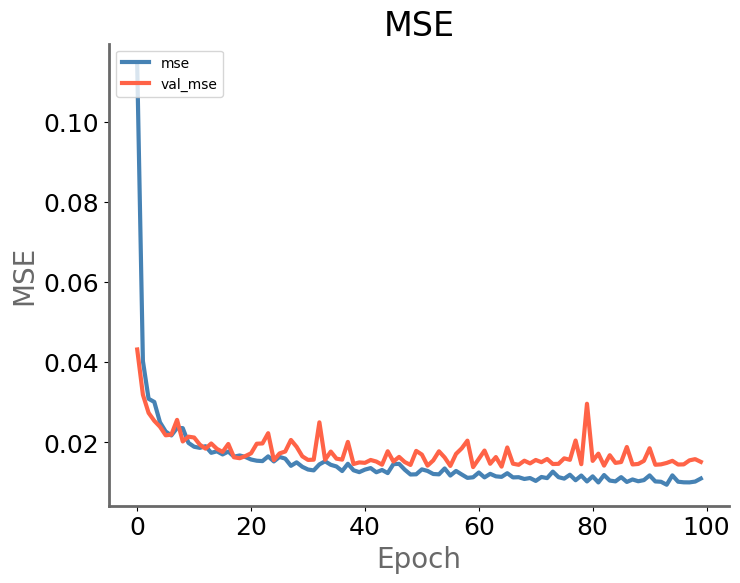

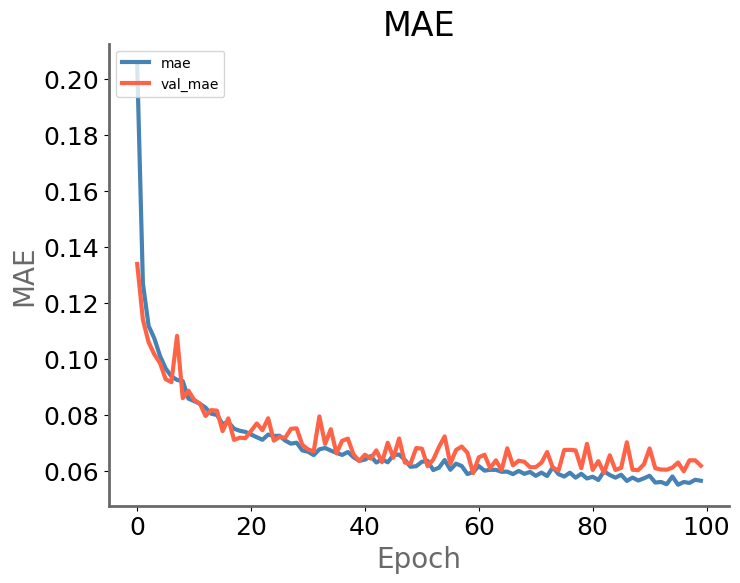

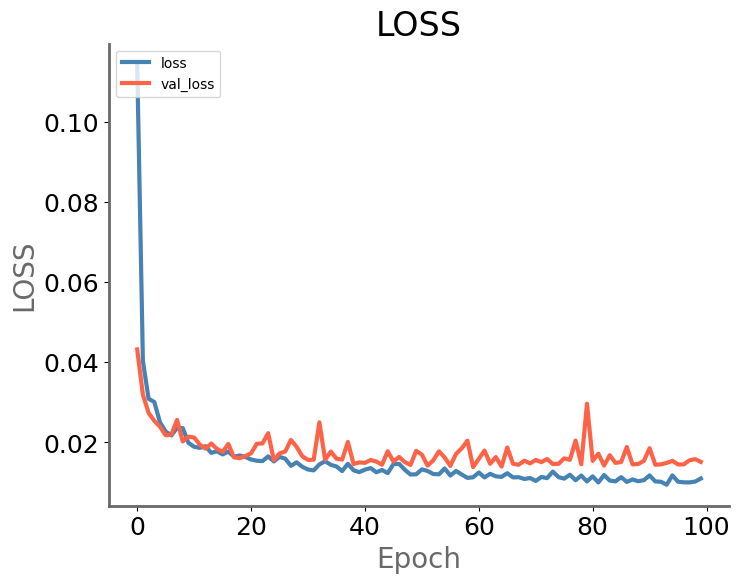

In [15]:
fidle.scrawler.history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Make a prediction
The data must be normalized with the parameters (mean, std) previously used.

In [16]:
my_data=x_test

In [17]:
predictions = model.predict( my_data )

593/593 [==============================] - 0s 440us/step


In [18]:
zspec = y_test
zphoto = predictions.T

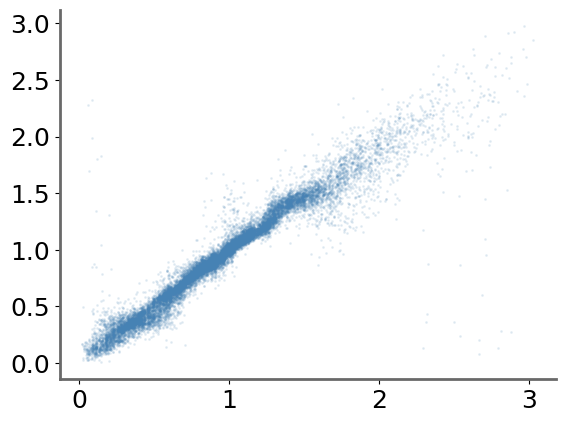

In [19]:
plt.scatter(zspec,zphoto,marker='.',s=5,alpha=0.1)

In [20]:
fidle.end()

**End time :** 02/04/23 14:02:27  
**Duration :** 00:01:13 958ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)